# Keras tutorial - Распознавание эмоций на изображениях лиц

В рамках данной лабораторной работы:
1. Изучите Keras, высокоуровневый API для нейронных сетей (programming framework), написанный на Python и способный работать поверх нескольких низкоуровневых фреймворков, включая TensorFlow и CNTK. 
2. Построите алгоритм глубокого обучения.

#### Зачем использовать Keras? 

* Keras был разработан инженрами и специалистами в области глубокого обучения для быстрого построения моделей
* TensorFlow является фреймворком высокого уровня, Keras является более высокоуровневым фреймворком и предоставляет дополнительные абстракции. 
* Способность перейти от идеи к результату с наименьшей возможной задержкой является ключом к поиску хороших моделей. 
* Однако Keras имеет больше ограничений, чем фреймворки низкого уровня, поэтому очень сложные модели необходимо реализовывать в TensorFlow , а не в Keras. 
* Тем не менее, Keras будет отлично работать для множества популярных моделей.

`Данный notebook использует материалы курса Deep Learning от организации deeplearning.ai`
 
 Ссылка на основной курс (для желающих получить сертификаты): https://www.coursera.org/specializations/deep-learning

## 1 - Пакеты/Библиотеки

In [55]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

## 1 - Отслеживание эмоций

* Необходимо создать приложение, которое классифицирует эмоции человека на "happy" и "not happy".

Пример датасета на изображении:
<img src="images/face_images.png" style="width:550px;height:250px;">

In [56]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Нормализация
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


## 2 - Построение модели в Keras

В Keras можно быстро делать прототип моделей, вот пример одной из них:
```python
def model(input_shape):
    """
    input_shape:  (height, width, channels) - tuple.  
    """
    
    # Определение входного tensor с размером input_shape (размер изображения).
    X_input = Input(input_shape)

    # Zero-Padding: заполнение X_input нулями по краям изображения
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (конвертирование в вектор) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Создание экземпляра модели Keras, вы будете использовать этот экземпляр для обучения тестирования модели.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

#### Наименование переменных

* Обратите внимание, что Keras использует другое соглашение с именами переменных, чем ранее использовался с numpy и TensorFlow. 
* Вместо создания уникальных имен переменных для каждого шага и каждого слоя, таких как
```
X = ...
Z1 = ...
A1 = ...
```
* Keras перезаписывает переменную на каждом шаге:
```
X = ...
X = ...
X = ...
```
* Исключение составляет `X_input`, который необходимо держать отдельно, так как он используется позже.

#### Объекты, как функции
* Обратите внимание, что в каждом операторе есть две пары скобок. Например:
```
X = ZeroPadding2D((3, 3))(X_input)
```
* Первая - это вызов конструктора, который создает объект (ZeroPadding2D).
* В Python объекты могут быть вызваны как функции. Более подробно об этом можно прочитать в блоге:[Python Pandemonium](https://medium.com/python-pandemonium/function-as-objects-in-python-d5215e6d1b0d).
```
ZP = ZeroPadding2D((3, 3)) # ZP, который вызывается как функция
X = ZP(X_input) 
```

**Задача**: Реализовать функцию `HappyModel()`.  
* Существуют различные функции активации `AveragePooling2D()`, `GlobalMaxPooling2D()`, `Dropout()`. 

In [59]:
def HappyModel(input_shape):
    """
    Реализация HappyModel.
    
    Arguments:
    input_shape -- размер изображения
        (height, width, channels) - tuple.  
    Returns:
        model -- Model() объект Keras

    """
    X_input = Input(input_shape, name="images")

    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    model = Model(inputs=X_input, outputs=X, name='HappyModel')    
    return model

После построения самой модели необходимо её обучить и протестировать. 

Необходимо выполнить четыре шага:
1. Создать модель, вызвав функцию выше  

2. Скомпилировать модель, вызвав - `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`  

3. Обучить модель,вызвав - `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`  

4. Протестировать модель - `model.evaluate(x = ..., y = ...)`  

Более подробно про `model.compile()`, `model.fit()`, `model.evaluate()` в официальной документации [Keras documentation](https://keras.io/models/model/).

#### Step 1: Создание модели

In [60]:
happyModel = HappyModel(X_train.shape[1:])

#### Step 2: Компиляция модели

Оптимизаторы - [optimizers](https://keras.io/optimizers/)  
Можно использовать функцию потерь `'binary_cross_entropy'` - [losses](https://keras.io/losses/)

In [61]:
happyModel.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

#### Step 3: Обучение модели

**Заметка**: Если вы снова запустите `fit()`, то `model` будет продолжать обучаться с уже изученными параметрами вместо их повторной инициализации.

In [62]:
happyModel.fit(X_train, Y_train, epochs=20, batch_size=50)

Epoch 1/20
12/12 [==============================] - 1s 99ms/step - loss: 2.8971 - accuracy: 0.5442
Epoch 2/20
12/12 [==============================] - 1s 97ms/step - loss: 0.8227 - accuracy: 0.6702
Epoch 3/20
12/12 [==============================] - 1s 100ms/step - loss: 0.2009 - accuracy: 0.9263
Epoch 4/20
12/12 [==============================] - 1s 99ms/step - loss: 0.1731 - accuracy: 0.9296
Epoch 5/20
12/12 [==============================] - 1s 94ms/step - loss: 0.1184 - accuracy: 0.9591
Epoch 6/20
12/12 [==============================] - 1s 105ms/step - loss: 0.1002 - accuracy: 0.9762
Epoch 7/20
12/12 [==============================] - 1s 101ms/step - loss: 0.0867 - accuracy: 0.9837
Epoch 8/20
12/12 [==============================] - 1s 98ms/step - loss: 0.0901 - accuracy: 0.9765
Epoch 9/20
12/12 [==============================] - 1s 101ms/step - loss: 0.0615 - accuracy: 0.9845
Epoch 10/20
12/12 [==============================] - 1s 99ms/step - loss: 0.0646 - accuracy: 0.9862
Epoch

#### Step 4: Оценка модели


In [63]:
preds = happyModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 0s 12ms/step - loss: 0.4134 - accuracy: 0.7000

Loss = 0.41342848539352417
Test Accuracy = 0.699999988079071


#### Советы по улучшению вашей модели


- Используйте блоки CONV->BATCHNORM->RELU, такие как:
```python
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
- Используйте MAXPOOL после таких блоков. Это поможет уменьшить размер по высоте и ширине.
- Измените оптимизатор.
- Запускайте больше эпох, пока не увидите, что точность на обучении больше не улучшается.

## 3 - Выводы

## Ключевые моменты, которые нужно запомнить
- Keras - это инструмент, который рекомендуется для быстрого прототипирования. Это позволяет быстро опробовать различные архитектуры моделей.
- Помните четыре шага в Keras: 
1. Создавать 
2. Компилировать 
3. Fit/Train 
4. Evaluate/Test

## 4 - Тестирование на своих изображениях

[[0.]]


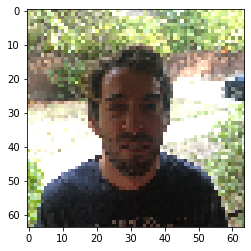

In [70]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))

## 5 - Другие полезные функции

Другие полезные функции Keras:: 
- `model.summary()`: выводит сведения о слоях в таблицу с размерами входов/выходов
- `plot_model()`: строит график в красивом макете. Вы даже можете сохранить его как ".png " с помощью SVG().

In [65]:
happyModel.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0

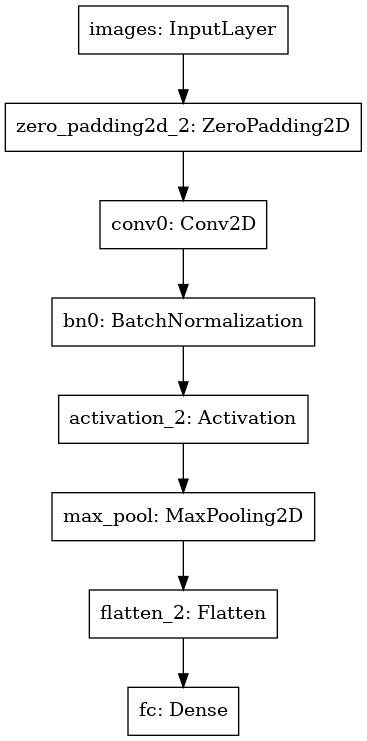

In [66]:
plot_model(happyModel, to_file='HappyModel.png')
# SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))

## 6 - Сохранение модели

In [67]:
happyModel.save('./models')

INFO:tensorflow:Assets written to: ./models/assets


In [ ]:
# import requests
# import json
# v = [list([list([int(i) for i in e]) for e in l]) for l in list(X_train_orig[0])]
# headers = {"Content-Type": "application/json"}
# resp = requests.post("http://localhost:8501/v1/models/happy_face/versions/1:predict", 
#               data=json.dumps({"inputs": {"images": [v]}}),  headers=headers, verify=False)
# json.loads(resp.text)